<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/manuscript/scrna/scrna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/KrishnaswamyLab/MAGIC
!git clone https://github.com/zsteve/wtf
!pip install magic-impute
!pip install tensorly
!pip install scanpy
!pip install pykeops[colab]
!git clone https://github.com/ComputationalSystemsBiology/ot-scOmics

Cloning into 'MAGIC'...
remote: Enumerating objects: 4436, done.
remote: Counting objects: 100% (359/359), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 4436 (delta 176), reused 240 (delta 107), pack-reused 4077
Receiving objects: 100% (4436/4436), 221.54 MiB | 49.75 MiB/s, done.
Resolving deltas: 100% (2314/2314), done.
Cloning into 'wtf'...
remote: Enumerating objects: 9429, done.
remote: Counting objects: 100% (9429/9429), done.
remote: Compressing objects: 100% (7319/7319), done.
remote: Total 9429 (delta 2186), reused 9313 (delta 2090), pack-reused 0
Receiving objects: 100% (9429/9429), 110.06 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (2186/2186), done.
Checking out files: 100% (8560/8560), done.
     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 112kB 9.4MB/s 
     |████████████████████████████████| 1.8MB 42.2MB/s 
     |████████████████████████████████| 163kB 6.3MB/s 
     |████████████████████████████████

In [1]:
import magic
import scprep
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
PLT_CELL = 2.5

In [3]:
X = pd.read_csv('/content/ot-scOmics/data/liu_scrna_preprocessed.csv.gz', index_col=0)
X_orig = copy.copy(X)
X[np.random.uniform(size = X.shape) < 0.9] = 0

In [4]:
clusters = np.array([col.split('_')[-1] for col in X.columns])
clusters_id = np.unique(clusters, return_inverse = True)[1]

In [5]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(X.T)

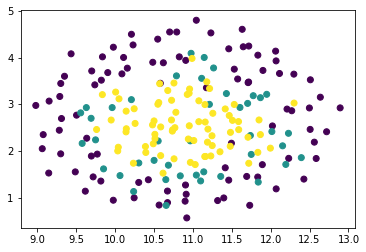

In [6]:
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters_id)

In [7]:
X_norm = np.array(X/X.sum(0))

In [8]:
import torch
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor


tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64


In [9]:
import sys
sys.path.insert(0, "/content/wtf/src")
import wtf

In [10]:
genenames = X.index.values

In [11]:
x = tl.tensor(np.array(X), dtype = tl_dtype).to(device)
expressed_tot = x.sum(1)
thresh = np.quantile(expressed_tot.cpu(), 0.25)
expressed_idx = (x.sum(1) > thresh).cpu()
# expressed_idx = expressed_idx | ((genenames == 'VIM') | (genenames == 'CDH1') | (genenames == 'ZEB1'))

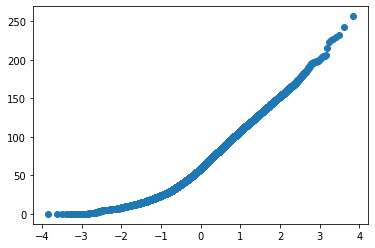

In [12]:
import scipy
from scipy import stats
plt.scatter(*scipy.stats.probplot(expressed_tot.cpu())[0])

In [13]:
expressed_idx = expressed_idx.bool()

In [14]:
x.shape

torch.Size([10994, 206])

In [15]:
import pykeops
from pykeops.torch import LazyTensor
x = x[expressed_idx, :]
x = x/x.sum(0)
gene_means = x.mean(1).reshape(-1, 1)
gene_dev = torch.sqrt(((x - gene_means)**2).sum(1)).reshape(-1, 1)
x_std = (x - gene_means)/gene_dev
x_i = LazyTensor(x_std.view(1, x.shape[0], x.shape[1]))
x_j = LazyTensor(x_std.view(x.shape[0], 1, x.shape[1]))

In [26]:
C = (1 - (x_std @ x_std.T) + 1e-9).sqrt()
# C = 1 - (x_i * x_j).sum(2)

In [27]:
import sklearn
from sklearn import decomposition
import copy
r_nmf = [10, ]*2
S_nmf = tl.zeros(r_nmf).to(device)
for i in range(r_nmf[0]):
    S_nmf[i, i] = 1

X0_nmf = (x.T).to(device)
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd", max_iter = 1)
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)

U_nmf = (U_nmf.T/U_nmf.sum(1)).T
V_nmf = (V_nmf.T/V_nmf.sum(1)).T

A_nmf = copy.deepcopy([U_nmf, V_nmf.T])
A_nmf = [a.to(device) for a in A_nmf]

In [28]:
params_nmf = {"n_iter" : 10}
params_nmf['lr'] = np.ones(params_nmf['n_iter'])*1
params_nmf['lamda'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*10
params_nmf['optim_modes'] = [0, ]
params_nmf['rho'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.01
params_nmf['eps'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.05

In [29]:
import importlib
importlib.reload(wtf)

<module 'wtf' from '/content/wtf/src/wtf.py'>

In [ ]:
max_iter, print_inter, check_iter, unbal = (100, 10, 10, False)
tol = 1e-2
mode = "lbfgs"
for i in range(params_nmf['n_iter']):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0_nmf, 0, [C, ], S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "row")
    wtf.solve(m0, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0_nmf, 1, [C, ], S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    wtf.solve(m1, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[1] = m1.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = -12.772179
i = 10 	 dual = -18.399314
Mode 1
i = 0 	 dual = 17.716477
i = 10 	 dual = 8.232881
i = 20 	 dual = 0.933092
i = 30 	 dual = -7.594678
i = 40 	 dual = -11.932325
i = 50 	 dual = -15.715214
i = 60 	 dual = -16.697883
i = 70 	 dual = -17.248751
i = 80 	 dual = -17.611277
i = 90 	 dual = -17.869682
Block iteration  1
Mode 0
i = 0 	 dual = -3.561917
i = 10 	 dual = -19.657669
i = 20 	 dual = -19.667749
Mode 1
i = 0 	 dual = 15.767559
i = 10 	 dual = -0.898893
i = 20 	 dual = -12.928384
i = 30 	 dual = -17.084557
i = 40 	 dual = -17.999941
i = 50 	 dual = -18.410751
i = 60 	 dual = -18.706118
i = 70 	 dual = -18.874402
i = 80 	 dual = -19.032221
i = 90 	 dual = -19.120117
Block iteration  2
Mode 0
i = 0 	 dual = -5.530453
i = 10 	 dual = -16.783104
Mode 1
i = 0 	 dual = 15.835419
i = 10 	 dual = -0.673951
i = 20 	 dual = -13.189214
i = 30 	 dual = -17.036718
i = 40 	 dual = -17.861299
i = 50 	 dual = -18.256368
i = 60 	 dual = -18.576655
i

In [79]:
X_hat_nmf = tl.tenalg.multi_mode_dot(S_nmf, A_nmf ).cpu()
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd")
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)
X_nmf = U_nmf @ V_nmf

(-0.5, 9.5, 8244.5, -0.5)

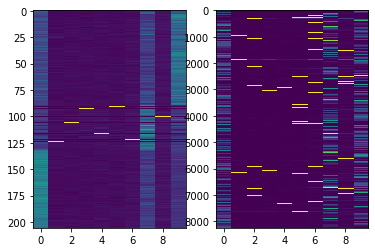

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(A_nmf[0].cpu(), interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 2, 2)
plt.imshow(A_nmf[1].cpu(), interpolation = "nearest", vmax = 1e-3)
plt.axis("auto")

(-0.5, 9.5, 8244.5, -0.5)

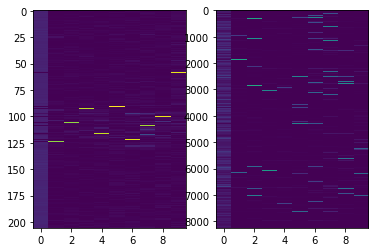

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(U_nmf, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 2, 2)
plt.imshow(V_nmf.T, interpolation = "nearest")
plt.axis("auto")

(-0.5, 8244.5, 205.5, -0.5)

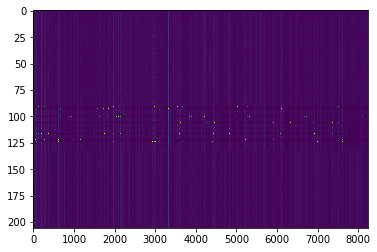

In [ ]:
plt.imshow(X_hat_nmf, interpolation = 'nearest', vmax = 0.005)
plt.axis("auto")

(-0.5, 8244.5, 205.5, -0.5)

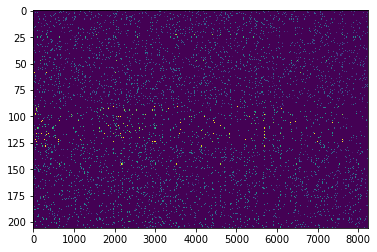

In [ ]:
plt.imshow(x.cpu().T, interpolation = 'nearest', vmax = 0.005)
plt.axis('auto')

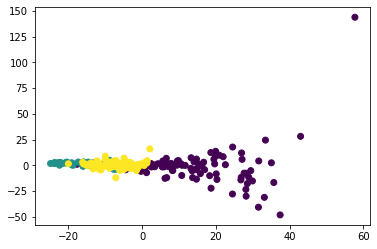

In [ ]:
pca = sklearn.decomposition.PCA(n_components = 2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = clusters_id)

Text(0.5, 1.0, 'WNMF')

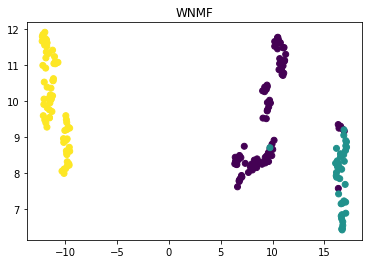

In [ ]:
embedding = reducer.fit_transform(A_nmf[0].cpu())
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters_id)
plt.title("WNMF")

Text(0.5, 1.0, 'NMF')

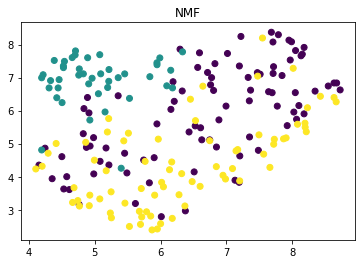

In [ ]:
embedding = reducer.fit_transform(U_nmf)
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters_id)
plt.title("NMF")

In [ ]:
embedding_orig = embed_umap.fit_transform(X_orig)
embedding = embed_umap.fit_transform(X_norm.T)
embedding_wnmf = embed_umap.fit_transform(X_hat_nmf)
embedding_nmf = embed_umap.fit_transform(X_nmf)

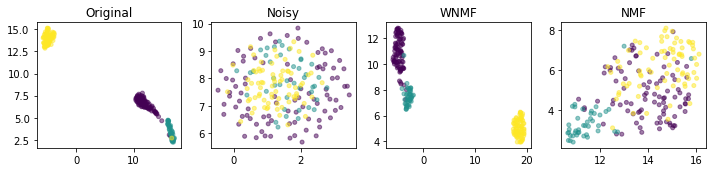

In [ ]:
import sklearn.manifold
embed_umap = umap.UMAP()
plt.figure(figsize = (4*PLT_CELL, 1*PLT_CELL))
plt.subplot(1, 4, 1)
plt.scatter(embedding_orig[:, 0], embedding_orig[:, 1], c = clusters_id, alpha = 0.5, s = 16)
plt.title("Original")
plt.subplot(1, 4, 2)
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters_id, alpha = 0.5, s = 16)
plt.title("Noisy")
plt.subplot(1, 4, 3)
plt.scatter(embedding_wnmf[:, 0], embedding_wnmf[:, 1], c = clusters_id, alpha = 0.5, s = 16)
plt.title("WNMF")
plt.subplot(1, 4, 4)
plt.scatter(embedding_nmf[:, 0], embedding_nmf[:, 1], c = clusters_id, alpha = 0.5, s = 16)
plt.title("NMF")
plt.tight_layout()
plt.savefig("liu_scrna_noisy0.9.pdf")

Text(0.5, 1.0, 'NMF')

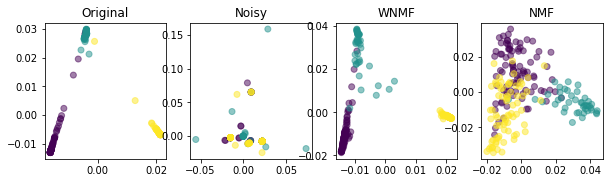

In [ ]:
import sklearn.manifold
embed_spec = sklearn.manifold.SpectralEmbedding()
plt.figure(figsize = (10, 2.5))
plt.subplot(1, 4, 1)
embedding = embed_spec.fit_transform(X_orig)
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters_id, alpha = 0.5)
plt.title("Original")
plt.subplot(1, 4, 2)
embedding = embed_spec.fit_transform(X)
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters_id, alpha = 0.5)
plt.title("Noisy")
plt.subplot(1, 4, 3)
embedding = embed_spec.fit_transform(X_hat_nmf)
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters_id, alpha = 0.5)
plt.title("WNMF")
plt.subplot(1, 4, 4)
embedding = embed_spec.fit_transform(X_nmf)
plt.scatter(embedding[:, 0], embedding[:, 1], c = clusters_id, alpha = 0.5)
plt.title("NMF")

Text(0, 0.5, 'cdh1')

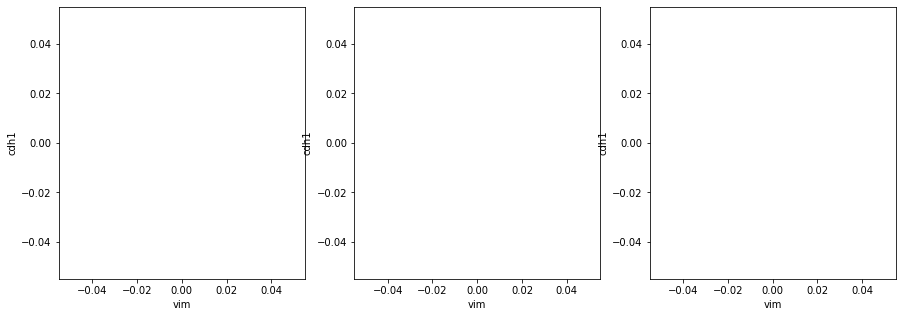

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_nmf[:, genenames[expressed_idx] == 'VIM'], X_nmf[:, genenames[expressed_idx] == 'CDH1'], 
           c = X_nmf[:, genenames[expressed_idx] == 'ZEB1'])
plt.xlabel('vim')
plt.ylabel('cdh1')

plt.subplot(1, 3, 2)
plt.scatter(X_hat_nmf[:, genenames[expressed_idx] == 'VIM'], X_hat_nmf[:, genenames[expressed_idx] == 'CDH1'], 
           c = X_hat_nmf[:, genenames[expressed_idx] == 'ZEB1'])
plt.xlabel('vim')
plt.ylabel('cdh1')

plt.subplot(1, 3, 3)
plt.scatter(X0_nmf[:, genenames[expressed_idx] == 'VIM'].cpu(), X0_nmf[:, genenames[expressed_idx] == 'CDH1'].cpu(), 
           c = X0_nmf[:, genenames[expressed_idx] == 'ZEB1'].cpu())
plt.xlabel('vim')
plt.ylabel('cdh1')